<a href="https://colab.research.google.com/github/mossfit/Active-Compound-Prediction/blob/main/Assignment_of_Bionsight_of_Compound_Active_Prediction_with_Novel_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install 'numpy<2'
!pip install rdkit-pypi torch  -f https://data.pyg.org/whl/torch-1.12.0+cu116.html scikit-learn matplotlib seaborn pandas

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
#import torch_scatter

from rdkit import Chem
from rdkit.Chem import AllChem

from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

sns.set_theme(style="whitegrid")
Device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {Device}")

Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu116.html
  Using cached rdkit_pypi-2022.9.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.9 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.17

In [ ]:
df = pd.read_csv('cmpd.csv')
print("Data head:")
print(df.head())

print("\nData info:")
df.info()

print("\nSplit:")
print(df['group'].value_counts())

print("\nTarget distribution:")
print(df['activity'].value_counts())

Data head:
                      inchikey  \
0  FNHKPVJBJVTLMP-UHFFFAOYSA-N   
1  CUDVHEFYRIWYQD-UHFFFAOYSA-N   
2  TTZSNFLLYPYKIL-UHFFFAOYSA-N   
3  UOVCGJXDGOGOCZ-UHFFFAOYSA-N   
4  CUIHSIWYWATEQL-UHFFFAOYSA-N   

                                              smiles  group activity  
0  CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)...  train   active  
1  CNC(=O)c1cccc2cc(Oc3ccnc4cc(OCC5(N)CC5)c(OC)cc...  train   active  
2  Cc1cc2cc(Oc3ccnc(Nc4cccc(CS(=O)(=O)NCCN(C)C)c4...   test   active  
3       COc1cc2c(cc1F)C(c1ccccc1Cl)=Nc1c(n[nH]c1C)N2  train   active  
4  Cc1ccc(Nc2nccc(N(C)c3ccc4c(C)n(C)nc4c3)n2)cc1S...   test   active  

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5530 entries, 0 to 5529
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   inchikey  5530 non-null   object
 1   smiles    5530 non-null   object
 2   group     5530 non-null   object
 3   activity  5530 non-null   object
dtypes: obje

In [ ]:
def one_hot_encoding(value, permitted_set):
    if value not in permitted_set:
        value = permitted_set[-1]
    return [int(value == s) for s in permitted_set]

def get_atom_features(atom):
    # Features 1:
    symbol = one_hot_encoding(atom.GetSymbol(), ['C', 'N', 'O', 'S', 'F', 'Cl', 'Br', 'I', 'P', 'B', 'Si', 'Unknown'])
    degree = one_hot_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5, 6])
    formal_charge = one_hot_encoding(atom.GetFormalCharge(), [-1, 0, 1])
    radical_electrons = one_hot_encoding(atom.GetNumRadicalElectrons(), [0, 1, 2])
    hybridization = one_hot_encoding(str(atom.GetHybridization()), ['SP', 'SP2', 'SP3', 'SP3D', 'SP3D2'])
    is_aromatic = [int(atom.GetIsAromatic())]
    num_hydrogens = one_hot_encoding(atom.GetTotalNumHs(), [0, 1, 2, 3, 4])
    return symbol + degree + formal_charge + radical_electrons + hybridization + is_aromatic + num_hydrogens

def get_bond_features(bond):
    # Features 2:
    bond_type = one_hot_encoding(bond.GetBondType(), [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC])
    is_conjugated = [int(bond.GetIsConjugated())]
    is_in_ring = [int(bond.IsInRing())]
    return bond_type + is_conjugated + is_in_ring

def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Node(atom) features
    atom_features = [get_atom_features(atom) for atom in mol.GetAtoms()]

    # Edge(bond) features and connectivity
    edge_index = []
    edge_features = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        # i now add edges in both directions for message passing
        edge_index.append((i, j))
        edge_index.append((j, i))

        bond_feats = get_bond_features(bond)
        edge_features.append(bond_feats)
        edge_features.append(bond_feats)

    if not edge_index: # i need to handle molecules with no bonds
        edge_index = np.empty((0, 2), dtype=np.int64)
        # i need to define a default length for edge features if no bonds exist
        edge_feature_len = 6
        edge_features = np.empty((0, edge_feature_len), dtype=np.float32)

    return {
        'x': np.array(atom_features, dtype=np.float32),
        'edge_index': np.array(edge_index, dtype=np.int64).T,
        'edge_attr': np.array(edge_features, dtype=np.float32)
    }

# using the function
df = pd.read_csv('cmpd.csv')
sample_smiles = df['smiles'].iloc[0]
graph = smiles_to_graph(sample_smiles)
print(f"SMILES: {sample_smiles}")
print(f"Node features shape: {graph['x'].shape}")
print(f"Edge index shape: {graph['edge_index'].shape}")
print(f"Edge features shape: {graph['edge_attr'].shape}")


SMILES: CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)c3)c(F)c2)ccn1
Node features shape: (33, 36)
Edge index shape: (2, 70)
Edge features shape: (70, 6)


In [ ]:
class MoleculeDataset(Dataset):
    def __init__(self, df):
        self.smiles = df['smiles'].values
        self.labels = df['active'].values

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smiles = self.smiles[idx]
        graph = smiles_to_graph(smiles)
        # i now handle cases where rdKit fails to parse SMILES
        if graph is None:
            # i am returning a dummy graph to skip this sample.
            # Here i will create a graph with a single node and no edges.
            print(f"Warning: Could not parse SMILES: {smiles}. Using a dummy graph.")
            graph = {'x': np.zeros((1, 39), dtype=np.float32),
                     'edge_index': np.empty((2, 0), dtype=np.int64),
                     'edge_attr': np.empty((0, 6), dtype=np.float32)}

        label = self.labels[idx]

        # totensors
        graph['x'] = torch.tensor(graph['x'], dtype=torch.float)
        graph['edge_index'] = torch.tensor(graph['edge_index'], dtype=torch.long)
        graph['edge_attr'] = torch.tensor(graph['edge_attr'], dtype=torch.float)
        label = torch.tensor([label], dtype=torch.float)

        return graph, label

def collate_fn(batch):
    # Filter out None
    batch = [b for b in batch if b is not None]
    if not batch:
        return None, None

    graphs, labels = zip(*batch)

    x_list, edge_index_list, edge_attr_list, batch_map = [], [], [], []
    node_offset = 0

    for i, graph in enumerate(graphs):
        num_nodes = graph['x'].shape[0]
        x_list.append(graph['x'])
        edge_index_list.append(graph['edge_index'] + node_offset)
        edge_attr_list.append(graph['edge_attr'])
        batch_map.append(torch.full((num_nodes,), i, dtype=torch.long))
        node_offset += num_nodes

    # Concatenate features into single tensors
    batched_x = torch.cat(x_list, dim=0)
    batched_edge_index = torch.cat(edge_index_list, dim=1)
    batched_edge_attr = torch.cat(edge_attr_list, dim=0)
    batched_batch_map = torch.cat(batch_map, dim=0)
    batched_labels = torch.cat(labels, dim=0)

    return {
        'x': batched_x,
        'edge_index': batched_edge_index,
        'edge_attr': batched_edge_attr,
        'batch': batched_batch_map
    }, batched_labels


In [ ]:
class MessagePassingLayer(nn.Module):
    def __init__(self, node_dim, edge_dim):
        super().__init__()
        # i am creating an MLP for message creation
        self.message_mlp = nn.Sequential(
            nn.Linear(2 * node_dim + edge_dim, 2 * node_dim),
            nn.ReLU(),
            nn.LayerNorm(2 * node_dim),
            nn.Linear(2 * node_dim, node_dim)
        )

    def forward(self, x, edge_index, edge_attr):
        row, col = edge_index
        message_inputs = torch.cat([x[row], x[col], edge_attr], dim=-1)
        messages = self.message_mlp(message_inputs)
        aggregated_messages = torch_scatter.scatter_add(messages, col, dim=0, dim_size=x.size(0))
        return aggregated_messages

class GlobalAttentionPool(nn.Module):
    def __init__(self, node_dim):
        super().__init__()
        self.gate_nn = nn.Linear(node_dim, 1)
        self.feat_nn = nn.Linear(node_dim, node_dim)

    def forward(self, x, batch):
        attention_scores = self.gate_nn(x)
        attention_scores = torch_scatter.scatter_softmax(attention_scores.view(-1), batch, dim=0)
        weighted_features = self.feat_nn(x) * attention_scores.view(-1, 1)
        graph_embedding = torch_scatter.scatter_add(weighted_features, batch, dim=0)
        return graph_embedding

class MPNN(nn.Module):
    def __init__(self, node_in_dim, edge_in_dim, node_hidden_dim, num_layers, readout_dim, dropout_rate):
        super().__init__()

        # creating dense initial feature encoders
        self.node_embed = nn.Sequential(
            nn.Linear(node_in_dim, node_hidden_dim),
            nn.ReLU(),
            nn.Linear(node_hidden_dim, node_hidden_dim)
        )
        self.edge_embed = nn.Sequential(
            nn.Linear(edge_in_dim, node_hidden_dim),
            nn.ReLU(),
            nn.Linear(node_hidden_dim, node_hidden_dim)
        )

        self.message_layers = nn.ModuleList()
        self.update_layers = nn.ModuleList()
        self.norm_layers = nn.ModuleList()

        for _ in range(num_layers):
            self.message_layers.append(MessagePassingLayer(node_hidden_dim, node_hidden_dim))
            self.update_layers.append(nn.GRUCell(node_hidden_dim, node_hidden_dim))
            self.norm_layers.append(nn.LayerNorm(node_hidden_dim))

        self.readout = GlobalAttentionPool(node_hidden_dim)

        # creating dense classifier
        self.classifier = nn.Sequential(
            nn.Linear(node_hidden_dim, readout_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(readout_dim, readout_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(readout_dim // 2, 1)
        )

    def forward(self, data):
        x, edge_index, edge_attr, batch = data['x'], data['edge_index'], data['edge_attr'], data['batch']

        h = self.node_embed(x)
        edge_attr_emb = self.edge_embed(edge_attr)

        for msg_layer, update_layer, norm_layer in zip(self.message_layers, self.update_layers, self.norm_layers):
            # Message passing
            messages = msg_layer(h, edge_index, edge_attr_emb)

            # Gated update with residual connection
            h_updated = update_layer(messages, h)
            h = h + h_updated # Residual connection

            # Normalization
            h = norm_layer(h)

        graph_embedding = self.readout(h, batch)
        self.graph_embeddings = graph_embedding

        out = self.classifier(graph_embedding)
        return torch.sigmoid(out)

In [ ]:
# Import train_test_split
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

SMILES_COLUMN = 'smiles'
TARGET_COLUMN = 'activity'


# helper functions
class MoleculeDataset(Dataset):
    def __init__(self, df, smiles_col, target_col):
        self.smiles = df[smiles_col].values
        self.labels = df[target_col].values

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smiles = self.smiles[idx]
        graph = smiles_to_graph(smiles)
        if graph is None:
            print(f"Warning: Could not parse SMILES: {smiles}. Using a dummy graph.")
            graph = {'x': np.zeros((1, 39), dtype=np.float32),
                     'edge_index': np.empty((2, 0), dtype=np.int64),
                     'edge_attr': np.empty((0, 6), dtype=np.float32)}

        label = self.labels[idx]

        graph['x'] = torch.tensor(graph['x'], dtype=torch.float)
        graph['edge_index'] = torch.tensor(graph['edge_index'], dtype=torch.long)
        graph['edge_attr'] = torch.tensor(graph['edge_attr'], dtype=torch.float)
        label = torch.tensor([label], dtype=torch.float)

        return graph, label


# Dataleader
df = pd.read_csv('cmpd.csv')

print("***Filtering Data for Binary Classification***")
if TARGET_COLUMN in df.columns:
    print(f"Original dataset size: {len(df)}")
    binary_labels = ['active', 'inactive']
    df = df[df[TARGET_COLUMN].isin(binary_labels)].copy()
    print(f"Filtered dataset to include only {binary_labels}.")
    print(f"New dataset size: {len(df)}")
else:
    print(f"Warning: Target column '{TARGET_COLUMN}' not found. Skipping filtering.")
print("-" * 50)


#DataPreprocessing:
print(f"*** Preprocessing Column: '{TARGET_COLUMN}' ***")
if TARGET_COLUMN in df.columns:
    unique_labels = df[TARGET_COLUMN].unique()
    print(f"Found unique labels: {unique_labels}")

    # Check column if already numeric
    if pd.api.types.is_numeric_dtype(df[TARGET_COLUMN]):
        print("Target column is already numeric. No conversion needed.")
    else:
        # If not numeric, assume it's categorical string
        if len(unique_labels) == 2:
            print("Found 2 unique string labels. Mapping to 1 and 0.")
            # Create a mapping-->active= 1, inactive= 0
            label_map = {'active': 1, 'inactive': 0}
            df[TARGET_COLUMN] = df[TARGET_COLUMN].map(label_map)
            print(f"Applied mapping: {label_map}")
            # Verify conversion
            print(f"New unique values in '{TARGET_COLUMN}': {df[TARGET_COLUMN].unique()}")
        else:
            raise ValueError(f"Expected 2 unique labels in target column '{TARGET_COLUMN}' for binary classification, but found {len(unique_labels)}. check data.")
else:
    print(f"Warning: Target column '{TARGET_COLUMN}' not found. skip preprocessing")
print("-" * 50)


# helper for debug
print("debug")
print("Columns available in cmpd.csv file:")
print(df.columns.tolist())
print(f"Script is configured to use: SMILES_COLUMN='{SMILES_COLUMN}', TARGET_COLUMN='{TARGET_COLUMN}'")
print("-" * 50)


try:
    # Data split
    train_df, test_df = train_test_split(
        df,
        test_size=0.2,
        random_state=42,
        stratify=df[TARGET_COLUMN]
    )

    # Creating datasets using the corrected class
    train_dataset = MoleculeDataset(train_df, smiles_col=SMILES_COLUMN, target_col=TARGET_COLUMN)
    test_dataset = MoleculeDataset(test_df, smiles_col=SMILES_COLUMN, target_col=TARGET_COLUMN)

    # Create dataloaders
    BATCH_SIZE = 128
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    # tuned model
    first_graph, _ = train_dataset[0]
    NODE_IN_DIM = first_graph['x'].shape[1]
    EDGE_IN_DIM = first_graph['edge_attr'].shape[1]

    NODE_HIDDEN_DIM = 256
    NUM_LAYERS = 6
    READOUT_DIM = 512
    DROPOUT_RATE = 0.4
    LEARNING_RATE = 5e-5
    WEIGHT_DECAY = 1e-5
    EPOCHS = 100

    # Instantiate model
    model = MPNN(
        node_in_dim=NODE_IN_DIM,
        edge_in_dim=EDGE_IN_DIM,
        node_hidden_dim=NODE_HIDDEN_DIM,
        num_layers=NUM_LAYERS,
        readout_dim=READOUT_DIM,
        dropout_rate=DROPOUT_RATE
    ).to(Device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    print("--- Model Initialized Successfully ---")
    print(model)
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")
    print("-" * 50)


except KeyError as e:
    print("\n" + "="*60)
    print("="*60)
    print(f"'KeyError' occurred @ the column name {e} was not found in csv file.")
    print("="*60 + "\n")
    raise e



***Filtering Data for Binary Classification***
Original dataset size: 5530
Filtered dataset to include only ['active', 'inactive'].
New dataset size: 4590
--------------------------------------------------
*** Preprocessing Column: 'activity' ***
Found unique labels: ['active' 'inactive']
Found 2 unique string labels. Mapping to 1 and 0.
Applied mapping: {'active': 1, 'inactive': 0}
New unique values in 'activity': [1 0]
--------------------------------------------------
debug
Columns available in cmpd.csv file:
['inchikey', 'smiles', 'group', 'activity']
Script is configured to use: SMILES_COLUMN='smiles', TARGET_COLUMN='activity'
--------------------------------------------------
--- Model Initialized Successfully ---
MPNN(
  (node_embed): Sequential(
    (0): Linear(in_features=36, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (edge_embed): Sequential(
    (0): Linear(in_features=6, out_features=256, bias=True)
    (

In [ ]:
!pip install torch-scatter

  Using cached torch_scatter-2.1.2.tar.gz (108 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp311-cp311-linux_x86_64.whl size=3622720 sha256=bedc60838c8463906b46818941ea715a9812a7728ab2bd08e23d5a16f663c173
  Stored in directory: /root/.cache/pip/wheels/b8/d4/0e/a80af2465354ea7355a2c153b11af2da739cfcf08b6c0b28e2
Successfully built torch-scatter


In [ ]:
import torch_scatter
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for data, labels in tqdm(loader, desc="Training", leave=False):
        if data is None:
            continue
        data = {k: v.to(device) for k, v in data.items()}
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for data, labels in loader:
            if data is None:
                continue
            data = {k: v.to(device) for k, v in data.items()}
            outputs = model(data)
            all_preds.append(outputs.cpu().numpy())
            all_labels.append(labels.numpy())

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()

    roc_auc = roc_auc_score(all_labels, all_preds)
    return roc_auc

history = {'train_loss': [], 'test_auc': []}

for epoch in range(1, EPOCHS + 1):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, Device)
    test_auc = evaluate(model, test_loader, Device)

    history['train_loss'].append(train_loss)
    history['test_auc'].append(test_auc)

    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.4f} | Test AUC: {test_auc:.4f}")


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 1/100 | Train Loss: 0.6778 | Test AUC: 0.7336


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 2/100 | Train Loss: 0.6501 | Test AUC: 0.7551


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 3/100 | Train Loss: 0.5834 | Test AUC: 0.8116


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 4/100 | Train Loss: 0.5239 | Test AUC: 0.8418


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 5/100 | Train Loss: 0.4871 | Test AUC: 0.8528


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 6/100 | Train Loss: 0.4641 | Test AUC: 0.8699


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 7/100 | Train Loss: 0.4366 | Test AUC: 0.8795


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 8/100 | Train Loss: 0.4314 | Test AUC: 0.8802


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 9/100 | Train Loss: 0.4127 | Test AUC: 0.8865


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 10/100 | Train Loss: 0.3914 | Test AUC: 0.8986


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 11/100 | Train Loss: 0.3802 | Test AUC: 0.9029


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 12/100 | Train Loss: 0.3690 | Test AUC: 0.9084


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 13/100 | Train Loss: 0.3683 | Test AUC: 0.9110


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 14/100 | Train Loss: 0.3487 | Test AUC: 0.9125


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 15/100 | Train Loss: 0.3451 | Test AUC: 0.9124


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 16/100 | Train Loss: 0.3443 | Test AUC: 0.9176


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 17/100 | Train Loss: 0.3262 | Test AUC: 0.9211


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 18/100 | Train Loss: 0.3203 | Test AUC: 0.9228


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 19/100 | Train Loss: 0.3263 | Test AUC: 0.9258


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 20/100 | Train Loss: 0.2995 | Test AUC: 0.9270


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 21/100 | Train Loss: 0.3021 | Test AUC: 0.9291


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 22/100 | Train Loss: 0.3049 | Test AUC: 0.9249


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 23/100 | Train Loss: 0.2856 | Test AUC: 0.9230


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 24/100 | Train Loss: 0.2807 | Test AUC: 0.9295


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 25/100 | Train Loss: 0.2706 | Test AUC: 0.9261


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 26/100 | Train Loss: 0.2681 | Test AUC: 0.9296


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 27/100 | Train Loss: 0.2677 | Test AUC: 0.9330


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 28/100 | Train Loss: 0.2684 | Test AUC: 0.9324


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 29/100 | Train Loss: 0.2547 | Test AUC: 0.9317


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 30/100 | Train Loss: 0.2676 | Test AUC: 0.9333


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 31/100 | Train Loss: 0.2511 | Test AUC: 0.9295


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 32/100 | Train Loss: 0.2506 | Test AUC: 0.9303


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 33/100 | Train Loss: 0.2367 | Test AUC: 0.9345


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 34/100 | Train Loss: 0.2339 | Test AUC: 0.9369


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 35/100 | Train Loss: 0.2254 | Test AUC: 0.9288


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 36/100 | Train Loss: 0.2281 | Test AUC: 0.9345


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 37/100 | Train Loss: 0.2260 | Test AUC: 0.9293


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 38/100 | Train Loss: 0.2209 | Test AUC: 0.9330


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 39/100 | Train Loss: 0.2142 | Test AUC: 0.9334


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 40/100 | Train Loss: 0.2111 | Test AUC: 0.9367


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 41/100 | Train Loss: 0.2048 | Test AUC: 0.9333


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 42/100 | Train Loss: 0.2074 | Test AUC: 0.9335


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 43/100 | Train Loss: 0.2084 | Test AUC: 0.9356


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 44/100 | Train Loss: 0.2065 | Test AUC: 0.9359


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 45/100 | Train Loss: 0.1996 | Test AUC: 0.9349


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 46/100 | Train Loss: 0.1882 | Test AUC: 0.9366


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 47/100 | Train Loss: 0.1875 | Test AUC: 0.9391


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 48/100 | Train Loss: 0.1843 | Test AUC: 0.9253


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 49/100 | Train Loss: 0.1900 | Test AUC: 0.9315


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 50/100 | Train Loss: 0.1778 | Test AUC: 0.9346


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 51/100 | Train Loss: 0.1906 | Test AUC: 0.9352


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 52/100 | Train Loss: 0.1712 | Test AUC: 0.9372


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 53/100 | Train Loss: 0.1718 | Test AUC: 0.9315


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 54/100 | Train Loss: 0.1691 | Test AUC: 0.9293


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 55/100 | Train Loss: 0.1673 | Test AUC: 0.9340


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 56/100 | Train Loss: 0.1601 | Test AUC: 0.9296


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 57/100 | Train Loss: 0.1641 | Test AUC: 0.9311


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 58/100 | Train Loss: 0.1613 | Test AUC: 0.9344


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 59/100 | Train Loss: 0.1569 | Test AUC: 0.9269


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 60/100 | Train Loss: 0.1590 | Test AUC: 0.9316


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 61/100 | Train Loss: 0.1554 | Test AUC: 0.9236


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 62/100 | Train Loss: 0.1511 | Test AUC: 0.9294


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 63/100 | Train Loss: 0.1448 | Test AUC: 0.9283


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 64/100 | Train Loss: 0.1395 | Test AUC: 0.9247


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 65/100 | Train Loss: 0.1414 | Test AUC: 0.9282


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 66/100 | Train Loss: 0.1566 | Test AUC: 0.9120


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 67/100 | Train Loss: 0.1576 | Test AUC: 0.9302


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 68/100 | Train Loss: 0.1348 | Test AUC: 0.9262


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 69/100 | Train Loss: 0.1264 | Test AUC: 0.9308


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 70/100 | Train Loss: 0.1324 | Test AUC: 0.9295


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 71/100 | Train Loss: 0.1311 | Test AUC: 0.9269


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 72/100 | Train Loss: 0.1364 | Test AUC: 0.9306


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 73/100 | Train Loss: 0.1222 | Test AUC: 0.9247


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 74/100 | Train Loss: 0.1178 | Test AUC: 0.9236


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 75/100 | Train Loss: 0.1181 | Test AUC: 0.9259


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 76/100 | Train Loss: 0.1155 | Test AUC: 0.9239


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 77/100 | Train Loss: 0.1224 | Test AUC: 0.9219


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 78/100 | Train Loss: 0.1217 | Test AUC: 0.9267


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 79/100 | Train Loss: 0.1118 | Test AUC: 0.9269


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 80/100 | Train Loss: 0.1171 | Test AUC: 0.9258


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 81/100 | Train Loss: 0.1076 | Test AUC: 0.9224


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 82/100 | Train Loss: 0.1074 | Test AUC: 0.9257


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 83/100 | Train Loss: 0.1136 | Test AUC: 0.9244


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 84/100 | Train Loss: 0.1007 | Test AUC: 0.9230


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 85/100 | Train Loss: 0.1057 | Test AUC: 0.9252


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 86/100 | Train Loss: 0.1019 | Test AUC: 0.9230


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 87/100 | Train Loss: 0.1034 | Test AUC: 0.9197


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 88/100 | Train Loss: 0.0916 | Test AUC: 0.9243


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 89/100 | Train Loss: 0.0897 | Test AUC: 0.9240


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 90/100 | Train Loss: 0.1037 | Test AUC: 0.9203


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 91/100 | Train Loss: 0.1063 | Test AUC: 0.9202


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 92/100 | Train Loss: 0.0979 | Test AUC: 0.9210


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 93/100 | Train Loss: 0.1056 | Test AUC: 0.9186


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 94/100 | Train Loss: 0.1006 | Test AUC: 0.9227


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 95/100 | Train Loss: 0.0948 | Test AUC: 0.9222


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 96/100 | Train Loss: 0.0851 | Test AUC: 0.9239


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 97/100 | Train Loss: 0.0786 | Test AUC: 0.9229


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 98/100 | Train Loss: 0.0820 | Test AUC: 0.9179


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 99/100 | Train Loss: 0.1016 | Test AUC: 0.9233


Training:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 100/100 | Train Loss: 0.0963 | Test AUC: 0.9257


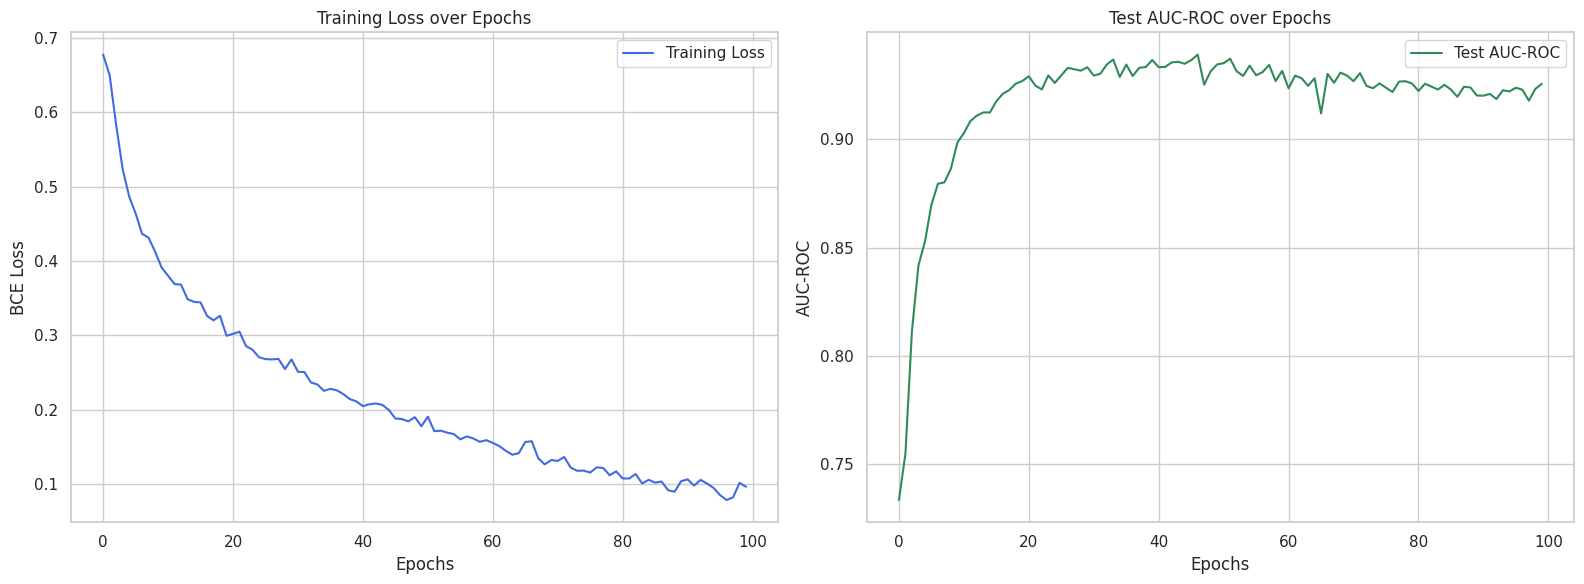

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot train loss
ax1.plot(history['train_loss'], label='Training Loss', color='royalblue')
ax1.set_title('Training Loss over Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('BCE Loss')
ax1.legend()

# Plot test auc
ax2.plot(history['test_auc'], label='Test AUC-ROC', color='seagreen')
ax2.set_title('Test AUC-ROC over Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('AUC-ROC')
ax2.legend()

plt.tight_layout()
plt.show()


Final Test Metrics:
  Accuracy:    0.8617
  Precision:   0.9059
  Recall:      0.8540
  F1-Score:    0.8792
  AUC-ROC:     0.9257


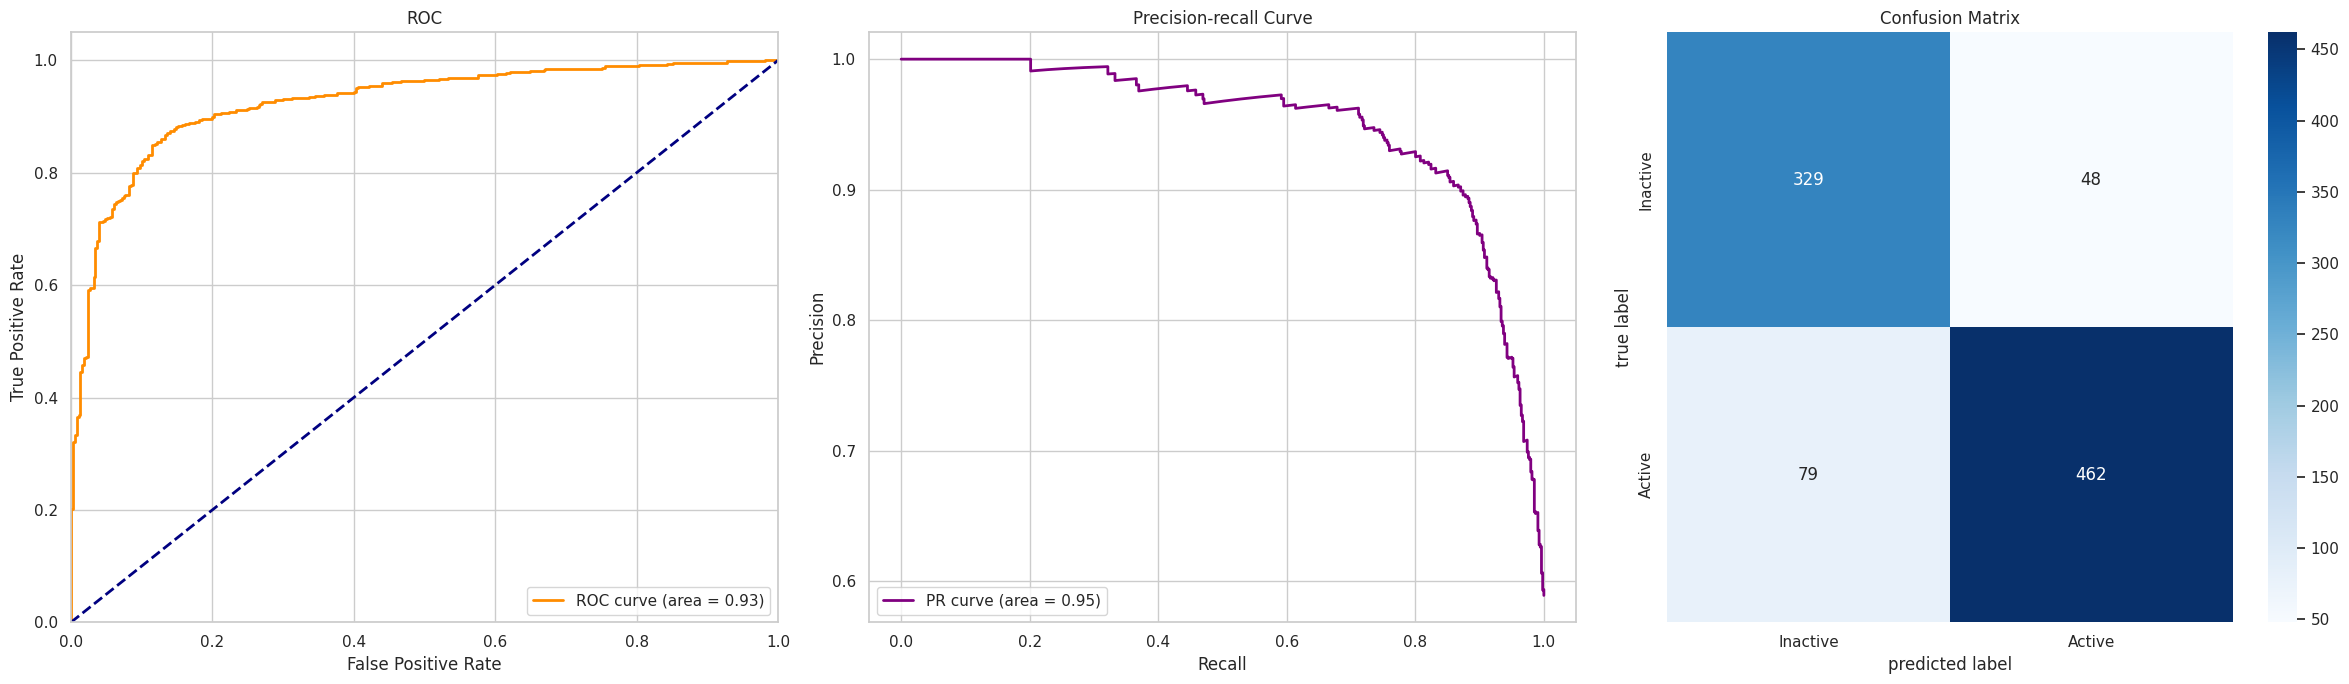

In [ ]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for data, labels in test_loader:
        if data is None:
            continue
        data = {k: v.to(Device) for k, v in data.items()}
        outputs = model(data)
        all_preds.append(outputs.cpu().numpy())
        all_labels.append(labels.numpy())

all_preds = np.concatenate(all_preds).ravel()
all_labels = np.concatenate(all_labels).ravel()
all_preds_binary = (all_preds > 0.5).astype(int)

accuracy = accuracy_score(all_labels, all_preds_binary)
precision = precision_score(all_labels, all_preds_binary)
recall = recall_score(all_labels, all_preds_binary)
f1 = f1_score(all_labels, all_preds_binary)
roc_auc = roc_auc_score(all_labels, all_preds)

print(f"Final Test Metrics:")
print(f"  Accuracy:    {accuracy:.4f}")
print(f"  Precision:   {precision:.4f}")
print(f"  Recall:      {recall:.4f}")
print(f"  F1-Score:    {f1:.4f}")
print(f"  AUC-ROC:     {roc_auc:.4f}")

fig, axes = plt.subplots(1, 3, figsize=(24, 7))

from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(all_labels, all_preds)
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC')
axes[0].legend(loc="lower right")


precision_vals, recall_vals, _ = precision_recall_curve(all_labels, all_preds)
pr_auc = auc(recall_vals, precision_vals)
axes[1].plot(recall_vals, precision_vals, color='purple', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-recall Curve')
axes[1].legend(loc="lower left")

cm = confusion_matrix(all_labels, all_preds_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[2],
            xticklabels=['Inactive', 'Active'], yticklabels=['Inactive', 'Active'])
axes[2].set_title('Confusion Matrix')
axes[2].set_xlabel('predicted label')
axes[2].set_ylabel('true label')

plt.tight_layout()
plt.show()


Generating embeddings:   0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


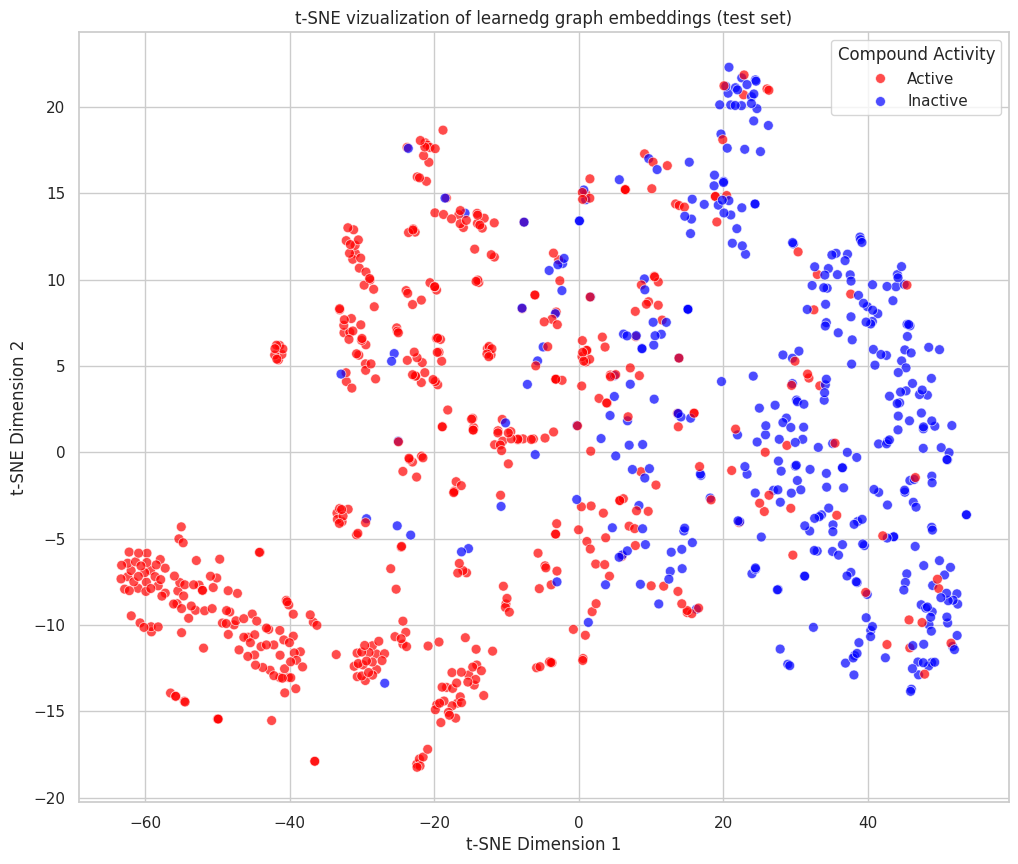

In [ ]:
model.eval()
all_embeddings = []
all_labels = []
with torch.no_grad():
    for data, labels in tqdm(test_loader, desc="Generating embeddings"):
        if data is None:
            continue
        data = {k: v.to(Device) for k, v in data.items()}
        # generate embeddings
        _ = model(data)
        all_embeddings.append(model.graph_embeddings.cpu().numpy())
        all_labels.append(labels.numpy())

all_embeddings = np.concatenate(all_embeddings, axis=0)
all_labels = np.concatenate(all_labels, axis=0).ravel()

# reduce dimensionality to 2D
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Create dataFrame
plot_df = pd.DataFrame({
    't-SNE-1': embeddings_2d[:, 0],
    't-SNE-2': embeddings_2d[:, 1],
    'label': ['Active' if l == 1 else 'Inactive' for l in all_labels]
})

# viz
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=plot_df,
    x='t-SNE-1',
    y='t-SNE-2',
    hue='label',
    palette={'Active': 'red', 'Inactive': 'blue'},
    alpha=0.7,
    s=50
)
plt.title('t-SNE vizualization of learnedg graph embeddings (test set)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Compound Activity')
plt.show()


Extracting Attention Weights:   0%|          | 0/8 [00:00<?, ?it/s]

/tmp/ipython-input-29-175757714.py:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('hot_r')


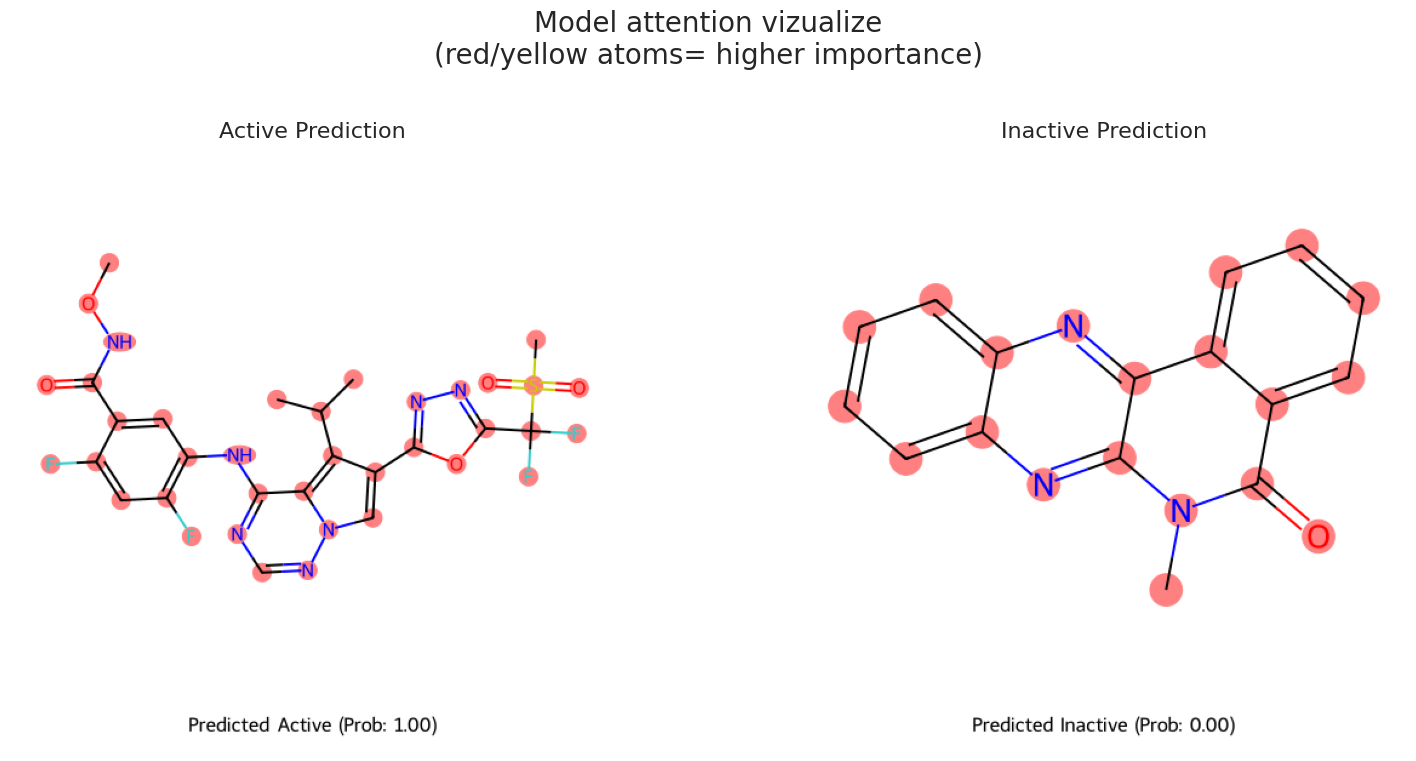

In [ ]:
# models attention viz
from rdkit.Chem import Draw
import matplotlib.cm as cm
from PIL import Image
from tqdm.notebook import tqdm
import torch.nn as nn
import torch_scatter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


class GlobalAttentionPoolWithScores(nn.Module):
    def __init__(self, node_dim):
        super().__init__()
        self.gate_nn = nn.Linear(node_dim, 1)
        self.feat_nn = nn.Linear(node_dim, node_dim)

    def forward(self, x, batch):
        attention_logits = self.gate_nn(x)
        attention_scores = torch_scatter.scatter_softmax(attention_logits.view(-1), batch, dim=0)
        weighted_features = self.feat_nn(x) * attention_scores.view(-1, 1)
        graph_embedding = torch_scatter.scatter_add(weighted_features, batch, dim=0)
        return graph_embedding, attention_scores # Return scores as well

class MPNNWithAttention(nn.Module):
    def __init__(self, node_in_dim, edge_in_dim, node_hidden_dim, num_layers, readout_dim, dropout_rate):
        super().__init__()
        # using trained model
        self.node_embed = nn.Sequential(nn.Linear(node_in_dim, node_hidden_dim), nn.ReLU(), nn.Linear(node_hidden_dim, node_hidden_dim))
        self.edge_embed = nn.Sequential(nn.Linear(edge_in_dim, node_hidden_dim), nn.ReLU(), nn.Linear(node_hidden_dim, node_hidden_dim))
        self.message_layers, self.update_layers, self.norm_layers = nn.ModuleList(), nn.ModuleList(), nn.ModuleList()
        for _ in range(num_layers):
            self.message_layers.append(MessagePassingLayer(node_hidden_dim, node_hidden_dim))
            self.update_layers.append(nn.GRUCell(node_hidden_dim, node_hidden_dim))
            self.norm_layers.append(nn.LayerNorm(node_hidden_dim))
        # using modified pool
        self.readout = GlobalAttentionPoolWithScores(node_hidden_dim)
        self.classifier = nn.Sequential(nn.Linear(node_hidden_dim, readout_dim), nn.ReLU(), nn.Dropout(dropout_rate), nn.Linear(readout_dim, readout_dim // 2), nn.ReLU(), nn.Dropout(dropout_rate), nn.Linear(readout_dim // 2, 1))
        # adding hooks to store intermediate results
        self.attention_scores = None
        self.graph_embeddings = None

    def forward(self, data):
        x, edge_index, edge_attr, batch = data['x'], data['edge_index'], data['edge_attr'], data['batch']
        h = self.node_embed(x)
        edge_attr_emb = self.edge_embed(edge_attr)
        for msg_layer, update_layer, norm_layer in zip(self.message_layers, self.update_layers, self.norm_layers):
            messages = msg_layer(h, edge_index, edge_attr_emb)
            h_updated = update_layer(messages, h)
            h = h + h_updated
            h = norm_layer(h)
        # Capture embedding of attention scores
        graph_embedding, attention_scores = self.readout(h, batch)
        self.graph_embeddings = graph_embedding
        self.attention_scores = attention_scores
        out = self.classifier(graph_embedding)
        return torch.sigmoid(out)


# Instantiate
attention_model = MPNNWithAttention(
    node_in_dim=NODE_IN_DIM, edge_in_dim=EDGE_IN_DIM, node_hidden_dim=NODE_HIDDEN_DIM,
    num_layers=NUM_LAYERS, readout_dim=READOUT_DIM, dropout_rate=DROPOUT_RATE
).to(Device)

attention_model.load_state_dict(model.state_dict())
attention_model.eval()


def draw_molecule_with_attention(smiles, atom_weights, title=""):
    """Draws a molecule and highlights atoms based on attention weights."""
    mol = Chem.MolFromSmiles(smiles)
    if not mol: return None
    norm_weights = (atom_weights - np.min(atom_weights)) / (np.max(atom_weights) - np.min(atom_weights) + 1e-6)
    cmap = cm.get_cmap('hot_r')
    atom_colors = {i: cmap(w) for i, w in enumerate(norm_weights)}

    img = Draw.MolToImage(mol,
                         highlightAtoms=list(range(mol.GetNumAtoms())),
                         highlightAtomColors=atom_colors,
                         legend=title,
                         size=(500, 500))
    return img

all_attention, all_preds, all_labels, all_batch_indices = [], [], [], []

with torch.no_grad():
    for i, (data, labels) in enumerate(tqdm(test_loader, desc="Extracting Attention Weights")):
        if data is None: continue
        data_to_device = {k: v.to(Device) for k, v in data.items()}
        outputs = attention_model(data_to_device)

        all_preds.append(outputs.cpu().numpy())
        all_labels.append(labels.numpy())

        all_attention.extend(attention_model.attention_scores.cpu().numpy().tolist())
        batch_map = data['batch'].cpu().numpy() + i * test_loader.batch_size
        all_batch_indices.extend(batch_map.tolist())

results_df = pd.DataFrame({
    'true_label': np.concatenate(all_labels).ravel(),
    'predicted_prob': np.concatenate(all_preds).ravel(),
})
attention_df = pd.DataFrame({
    'molecule_idx': all_batch_indices,
    'attention': all_attention
})

correct_active = results_df[(results_df['true_label'] == 1) & (results_df['predicted_prob'] > 0.95)]
correct_inactive = results_df[(results_df['true_label'] == 0) & (results_df['predicted_prob'] < 0.05)]

if not correct_active.empty and not correct_inactive.empty:
    # select each example
    active_idx = correct_active.index[0]
    inactive_idx = correct_inactive.index[0]

    # get smiles probability
    active_smiles = test_df[SMILES_COLUMN].iloc[active_idx]
    inactive_smiles = test_df[SMILES_COLUMN].iloc[inactive_idx]
    active_prob = results_df.loc[active_idx, 'predicted_prob']
    inactive_prob = results_df.loc[inactive_idx, 'predicted_prob']

    active_attention_weights = attention_df[attention_df['molecule_idx'] == active_idx]['attention'].values
    inactive_attention_weights = attention_df[attention_df['molecule_idx'] == inactive_idx]['attention'].values

    active_img = draw_molecule_with_attention(active_smiles, active_attention_weights, f"Predicted Active (Prob: {active_prob:.2f})")
    inactive_img = draw_molecule_with_attention(inactive_smiles, inactive_attention_weights, f"Predicted Inactive (Prob: {inactive_prob:.2f})")

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    axes[0].imshow(active_img)
    axes[0].set_title("Active Prediction", fontsize=16)
    axes[0].axis('off')

    axes[1].imshow(inactive_img)
    axes[1].set_title("Inactive Prediction", fontsize=16)
    axes[1].axis('off')

    fig.suptitle("Model attention vizualize\n(red/yellow atoms= higher importance)", fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()

else:
    print("Could not find")
    print("may happen with smaller test sets")


Creating directions for loss
Calculating loss on 15x15 grid....


Exploring dimension 1:   0%|          | 0/15 [00:00<?, ?it/s]

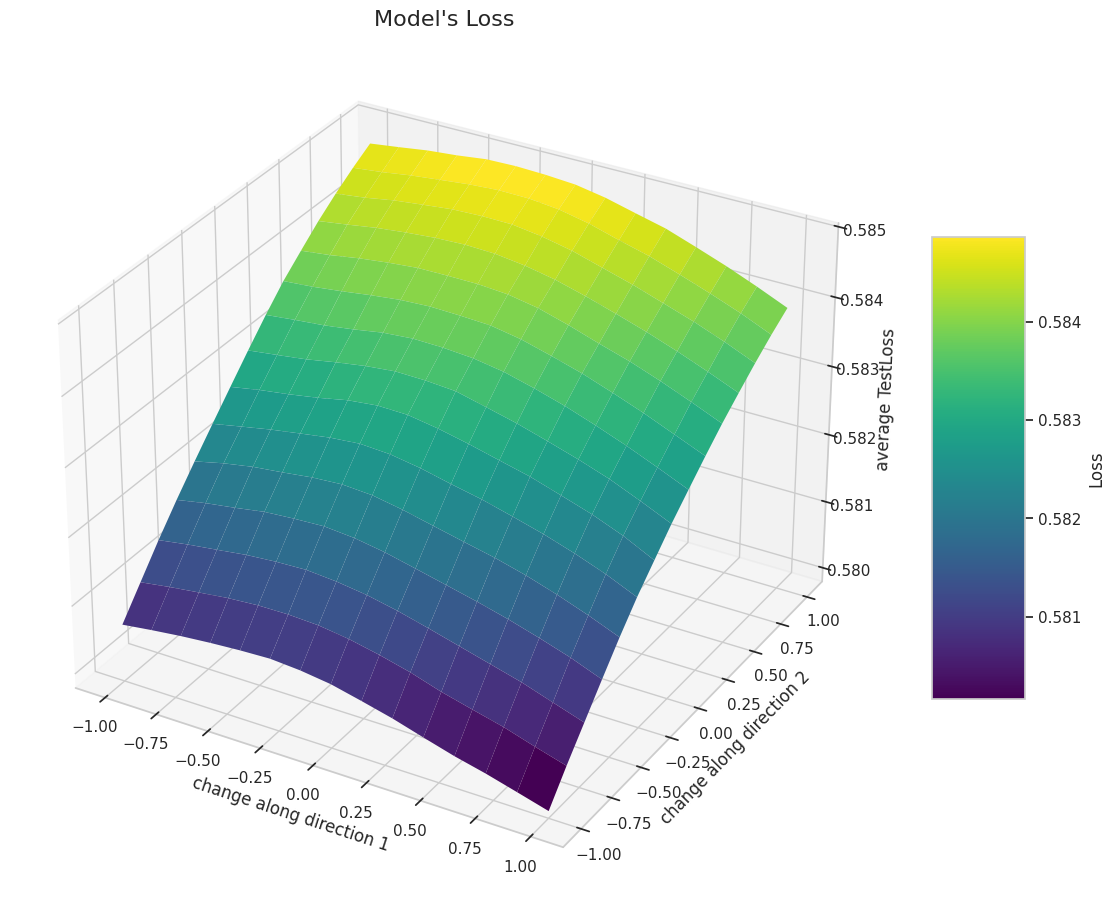

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm
import copy

def get_model_params(model):
    return torch.cat([p.data.view(-1) for p in model.parameters()])

def set_model_params(model, params_vector):
    offset = 0
    for p in model.parameters():
        p.data.copy_(params_vector[offset:offset + p.numel()].view(p.size()))
        offset += p.numel()

final_params = get_model_params(model)
print("Creating directions for loss")

direction1 = torch.randn(final_params.size()).to(Device)
direction2 = torch.randn(final_params.size()).to(Device)

direction1 /= torch.norm(direction1)
direction2 /= torch.norm(direction2)

direction2.sub_(torch.dot(direction1, direction2) * direction1)
direction2 /= torch.norm(direction2)

grid_range = 1.0
grid_points = 15
losses = np.zeros((grid_points, grid_points))

temp_model = copy.deepcopy(model).to(Device)
temp_model.eval()
criterion = torch.nn.BCELoss()

print(f"Calculating loss on {grid_points}x{grid_points} grid....")
x_coords = np.linspace(-grid_range, grid_range, grid_points)
y_coords = np.linspace(-grid_range, grid_range, grid_points)

for i, x in enumerate(tqdm(x_coords, desc="Exploring dimension 1")):
    for j, y in enumerate(y_coords):
        new_params = final_params + x * direction1 + y * direction2
        set_model_params(temp_model, new_params)

        # total loss for the test set
        total_loss = 0
        num_batches = 0
        with torch.no_grad():
            for data, labels in test_loader:
                if data is None: continue
                data_to_device = {k: v.to(Device) for k, v in data.items()}
                labels_to_device = labels.to(Device)

                outputs = temp_model(data_to_device)
                loss = criterion(outputs, labels_to_device.view(-1, 1))
                total_loss += loss.item()
                num_batches += 1
        losses[i, j] = total_loss / num_batches

X, Y = np.meshgrid(x_coords, y_coords)

fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot
surf = ax.plot_surface(X, Y, losses.T, cmap='viridis', edgecolor='none')

ax.set_title('Model\'s Loss', fontsize=16)
ax.set_xlabel('change along direction 1')
ax.set_ylabel('change along direction 2')
ax.set_zlabel('average TestLoss')
fig.colorbar(surf, shrink=0.5, aspect=5, label='Loss')

plt.show()
